# Predict fuel efficiency using Linear Regression ML Model

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.


## Install and import the required packages

In [1]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# What version of Tensorflow are we using?
print(tf.__version__)

2.8.2


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download and import the dataset using pandas. Also, save the file locally. 

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

# Save the dataset to the CSV file mpg.csv
raw_dataset.to_csv('mpg.csv', index=False)

Output some rows in the dataseet. MPG is the label (what we want to train the model to predict), the rest of the fields are the features. 

In [4]:
dataset = raw_dataset.copy()
dataset[30:40]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
30,28.0,4,140.0,90.0,2264.0,15.5,71,1
31,25.0,4,113.0,95.0,2228.0,14.0,71,3
32,25.0,4,98.0,NaN,2046.0,19.0,71,1
33,19.0,6,232.0,100.0,2634.0,13.0,71,1
34,16.0,6,225.0,105.0,3439.0,15.5,71,1
35,17.0,6,250.0,100.0,3329.0,15.5,71,1
36,19.0,6,250.0,88.0,3302.0,15.5,71,1
37,18.0,6,232.0,100.0,3288.0,15.5,71,1
38,14.0,8,350.0,165.0,4209.0,12.0,71,1
39,14.0,8,400.0,175.0,4464.0,11.5,71,1


### Inspecting and Cleaning the Data

Use the Pandas Dataframe describe() function to explore the data. If you're wondering what transpose() does, run the cell with and without it. 

Notice, the count property for Horsepower is less than for the rest of the fields. Something must be amiss. 

In [5]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
Cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
Displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
Weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
Acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
Model Year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
Origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In the code below, isna() returns if a value is not a number. Sum() will return the number of values for each field that isn't a number. This explains why Horsepower above had a lower count than the rest of the fields. 

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

The code below simply removes the rows that have invalid (non-numeric) data. In this case the 6 rows where the Horsepower field has a null value. An alternative would be to replace the null values with the mean Horsepower from the dataset. 

In [7]:
dataset = dataset.dropna()

Use the Seaborn pairplot() function to review the joint distribution of the pairs of columns from the training set. You are trying to visualize patterns than indicate a cooorelation between different fields and the label (MPG)

You can experiment with other fields or all the fields if you like. 

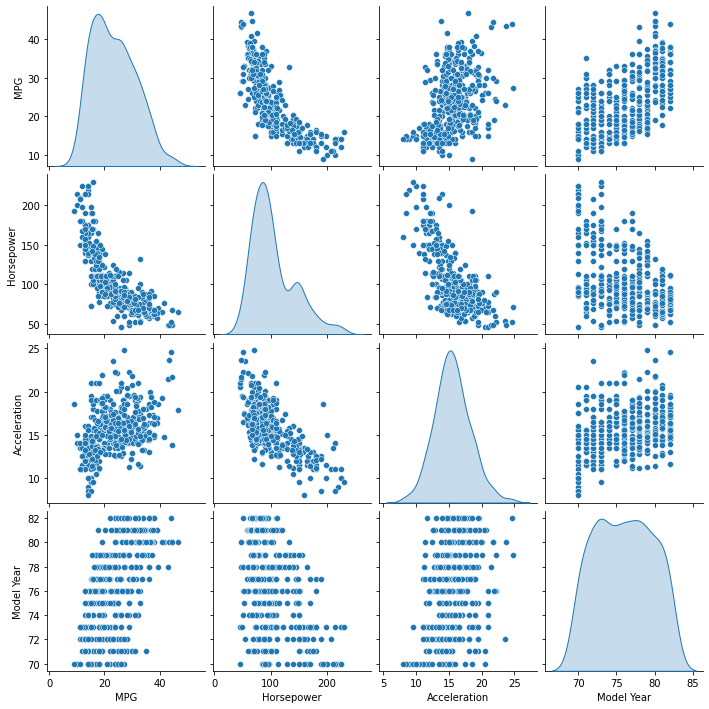

In [8]:
import seaborn as sns
sns.pairplot(dataset[['MPG', 'Horsepower', 'Acceleration', 'Model Year']], 
             diag_kind='kde')

## One-Hot Encoding

The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).



In [9]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 
                                           2: 'Europe', 
                                           3: 'Japan'})

dataset = pd.get_dummies(dataset, 
                         columns=['Origin'], 
                         prefix='Origin_', prefix_sep='')


dataset[30:40]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Europe,Origin_Japan,Origin_USA
30,28.0,4,140.0,90.0,2264.0,15.5,71,0,0,1
31,25.0,4,113.0,95.0,2228.0,14.0,71,0,1,0
33,19.0,6,232.0,100.0,2634.0,13.0,71,0,0,1
34,16.0,6,225.0,105.0,3439.0,15.5,71,0,0,1
35,17.0,6,250.0,100.0,3329.0,15.5,71,0,0,1
36,19.0,6,250.0,88.0,3302.0,15.5,71,0,0,1
37,18.0,6,232.0,100.0,3288.0,15.5,71,0,0,1
38,14.0,8,350.0,165.0,4209.0,12.0,71,0,0,1
39,14.0,8,400.0,175.0,4464.0,11.5,71,0,0,1
40,14.0,8,351.0,153.0,4154.0,13.5,71,0,0,1


## Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In this case, 80% of the data is randomly selected for training, and the rest will be used for testing. 

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Let's describe the training data. 

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin_Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Origin_Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
Origin_USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


Now, let's describe the test data. Because `transpose` is so often used, there is a shortcut of just a capital `T`.

In [12]:
test_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,78.0,23.991026,8.133563,9.0,18.00,24.00,29.875,44.3
Cylinders,78.0,5.448718,1.740633,3.0,4.00,4.00,8.000,8.0
Displacement,78.0,190.762821,106.494733,70.0,98.00,138.00,292.000,400.0
Horsepower,78.0,102.858974,40.255265,48.0,74.25,90.00,121.750,230.0
Weight,78.0,2926.589744,874.900416,1613.0,2159.50,2692.50,3706.500,4746.0
Acceleration,78.0,15.469231,2.649298,8.5,13.70,15.25,17.000,22.2
Model Year,78.0,76.307692,3.721847,70.0,73.00,76.00,79.750,82.0
Origin_Europe,78.0,0.153846,0.363137,0.0,0.00,0.00,0.000,1.0
Origin_Japan,78.0,0.217949,0.415525,0.0,0.00,0.00,0.000,1.0
Origin_USA,78.0,0.628205,0.486412,0.0,0.00,1.00,1.000,1.0


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [14]:
train_dataset.describe().T[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Origin_Europe,0.178344,0.383413
Origin_Japan,0.197452,0.398712
Origin_USA,0.624204,0.485101


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [16]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [17]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [18]:
first = np.array(train_features[:5])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]
 [   4.   140.    88.  2890.    17.3   79.     0.     0.     1. ]
 [   8.   350.   160.  4456.    13.5   72.     0.     0.     1. ]
 [   4.   105.    63.  2125.    14.7   82.     0.     0.     1. ]
 [   4.    97.    67.  2145.    18.    80.     0.     1.     0. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]
 [-0.87 -0.53 -0.44 -0.12  0.63  0.85 -0.47 -0.5   0.78]
 [ 1.49  1.48  1.45  1.74 -0.74 -1.06 -0.47 -0.5   0.78]
 [-0.87 -0.87 -1.1  -1.03 -0.31  1.66 -0.47 -0.5   0.78]
 [-0.87 -0.94 -1.   -1.    0.88  1.12 -0.47  2.02 -1.29]]


### Linear regression with one variable

Begin with a single-variable linear regression to predict `'MPG'` from `'Horsepower'`.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](.././guide/keras/sequential_model.ipynb).

There are two steps in your single-variable linear regression model:

- Normalize the `'Horsepower'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'Horsepower'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `horsepower` data:

In [19]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Build the Keras Sequential model:

In [20]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

In [21]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Having configured the training model, use Keras `Model.fit` to execute the training for 100 epochs:

In [22]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.42 s, sys: 158 ms, total: 3.57 s
Wall time: 3.41 s


Visualize the model's training progress using the stats stored in the `history` object:

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.head())
print(hist.tail())

        loss   val_loss  epoch
0  22.866772  22.931021      0
1  22.065084  22.130770      1
2  21.263842  21.330969      2
3  20.463358  20.530954      3
4  19.664482  19.731123      4
        loss  val_loss  epoch
95  3.804676  4.192931     95
96  3.805583  4.199447     96
97  3.805066  4.196017     97
98  3.808355  4.153477     98
99  3.811010  4.182516     99


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

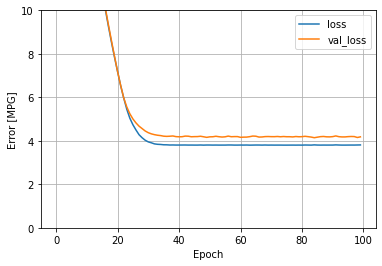

In [25]:
plot_loss(history)

Collect the results on the test set for later:

In [26]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [27]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [28]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

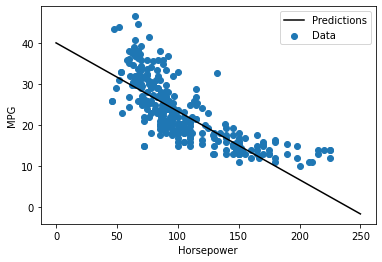

In [29]:
plot_horsepower(x,y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [30]:
all_features_normalizer = tf.keras.layers.Normalization(axis=-1)
all_features_normalizer.adapt(np.array(train_features))


linear_model = tf.keras.Sequential([
    all_features_normalizer,
    layers.Dense(units=1)
])

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [31]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [32]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.38 s, sys: 178 ms, total: 3.55 s
Wall time: 5.45 s


Using all the inputs in this regression model achieves a much lower training and validation error than the `horsepower_model`, which had one input:

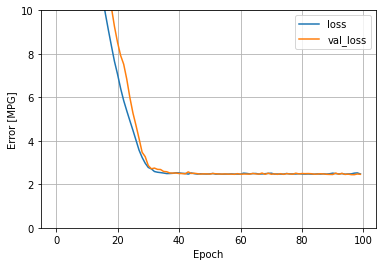

In [33]:
plot_loss(history)

Collect the results on the test set for later:

In [34]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance:

In [35]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.646335
linear_model,2.484526


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

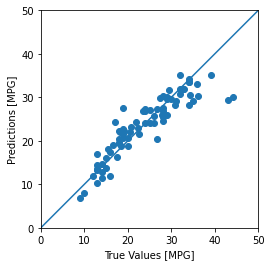

In [36]:
test_predictions = linear_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

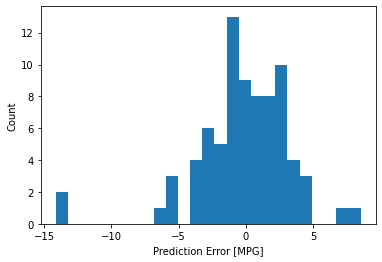

In [37]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [38]:
linear_model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


If you reload the model, it gives identical output:

In [39]:
reloaded = tf.keras.models.load_model('my_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [40]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.646335
linear_model,2.484526
reloaded,2.484526
